In this exercise, you'll predict house prices using your model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the housing prices data from Thinkful's database.
* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
* Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why?
* Try to improve your model in terms of predictive performance by adding or removing some variables.


In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")


In [28]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.outliers_influence import variance_inflation_factor


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [103]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()
drop_cols=[]
for col in df.columns:
    if df[col].isna().mean()>.4:
        drop_cols=drop_cols+[col]
df_clean=df.drop(columns=drop_cols).dropna()
df_clean['secondflrexists']=0
df_clean.loc[df['secondflrsf']>0,'secondflrexists']=1 #can prob drop 2nd fl sq ft
#df_clean['totalsf']=df_clean['firstflrsf']=+df_clean['secondflrsf']
df_clean['yrsbltqared']=df_clean['yearbuilt']*df_clean['yearbuilt']
df_clean['agebuilt']=df_clean['yrsold']-df_clean['yearbuilt']
df_clean['ageremodeled']=df_clean['yrsold']-df_clean['yearremodadd']
df_clean['agebuiltsquared']=df_clean['agebuilt']*df_clean['agebuilt']
df_clean['agebuiltcubed']=df_clean['agebuilt']*df_clean['agebuilt']*df_clean['agebuilt']

df_clean['ageremodeledsquared']=df_clean['ageremodeled']*df_clean['ageremodeled']
df_clean['totalsf']=df_clean['totalbsmtsf']+df_clean['grlivarea']

####

y=df_clean['saleprice']
X=df_clean.drop(columns=['saleprice','id'])
X.mszoning.dtype==int
cat_cols=[c for c in X.columns if X[c].dtype=='O']
numeric_cols=[c for c in X.columns if X[c].dtype!='O']
niceneighborhoods=['NridgHt', 'NoRidge', 'Somerst', 'Timber', 'Veenker', 'StoneBr']
df_clean['nicehood']=0
df_clean.loc[df_clean.neighborhood.isin(niceneighborhoods),'nicehood']=1
X2 = df_clean[['overallqual','grlivarea', 'garagearea', 'totalbsmtsf','yearremodadd','yearbuilt','yrsbltqared','lotarea','nicehood']]
Y2 = df_clean.saleprice

X_train, X_test, y_train, y_test=train_test_split(X2,Y2,test_size=.2,random_state=1)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)


In [104]:
results = sm.OLS(y_train, X_train_const).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     332.5
Date:                Wed, 02 Sep 2020   Prob (F-statistic):          9.07e-274
Time:                        18:33:31   Log-Likelihood:                -10496.
No. Observations:                 875   AIC:                         2.101e+04
Df Residuals:                     865   BIC:                         2.106e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.254e+07   6.59e+06     -3.422   

In [87]:
y_preds=results.predict(X_test_const)

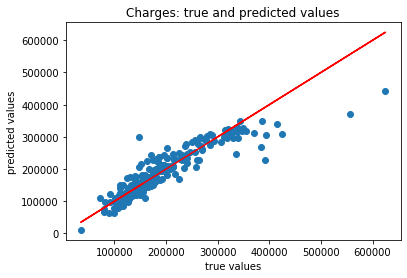

Mean absolute error of the prediction is: 23242.910051060768
Mean squared error of the prediction is: 1298733099.7997575
Root mean squared error of the prediction is: 36037.93972745608
Mean absolute percentage error of the prediction is: 12.518958730058419


In [88]:
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


You can see that it overpredicts at a few high values. How to deal with this? Probably adding a squared term somewhere would help. Or a log transform.

In [89]:
Y2_log=np.log(Y2)
X_train, X_test, y_log_train, y_log_test=train_test_split(X2,Y2_log,test_size=.2,random_state=1)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
results_log = sm.OLS(y_log_train, X_train_const).fit()
print(results_log.summary())
y_log_preds=results_log.predict(X_test_const)

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     400.1
Date:                Wed, 02 Sep 2020   Prob (F-statistic):          3.21e-301
Time:                        18:23:57   Log-Likelihood:                 295.02
No. Observations:                 875   AIC:                            -570.0
Df Residuals:                     865   BIC:                            -522.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -110.9591     29.028     -3.822   

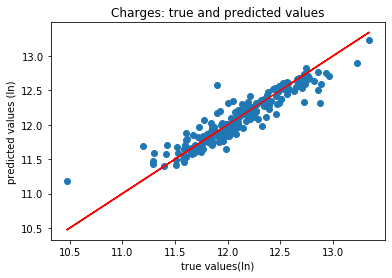

Mean absolute error of the prediction is: 23242.910051060768
Mean squared error of the prediction is: 1298733099.7997575
Root mean squared error of the prediction is: 36037.93972745608
Mean absolute percentage error of the prediction is: 12.518958730058419


In [90]:
plt.scatter(y_log_test, y_log_preds)
plt.plot(y_log_test, y_log_test, color="red")
plt.xlabel("true values(ln)")
plt.ylabel("predicted values (ln)")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


That looks really good! I think you have a couple of outliers with high leveridge messing it up.

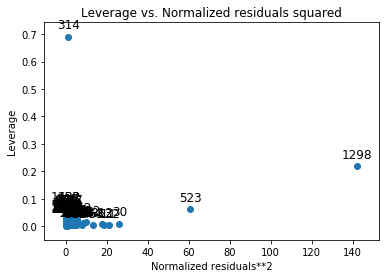

In [91]:
plot_leverage_resid2(results_log)
plt.show()

Can try witout these outlier points:

In [92]:
X_train.loc[[314,523,1298], :]
#y_train[314]#,523,1298]



,overallqual,grlivarea,garagearea,totalbsmtsf,yearremodadd,yearbuilt,yrsbltqared,lotarea,nicehood
314,7,2036,513,2136,1965,1965,3861225,215245,1
523,10,4676,884,3138,2008,2007,4028049,40094,0
1298,10,5642,1418,6110,2008,2008,4032064,63887,0


In [93]:
df_clean.loc[[314,523,1298], :]
#df_clean.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,saleprice,secondflrexists,yrsbltqared,agebuilt,ageremodeled,agebuiltsquared,agebuiltcubed,ageremodeledsquared,totalsf,nicehood
314,314,20,RL,150.0,215245,Pave,IR3,Low,AllPub,Inside,...,375000,0,3861225,44,44,1936,85184,1936,4172,1
523,524,60,RL,130.0,40094,Pave,IR1,Bnk,AllPub,Inside,...,184750,1,4028049,0,-1,0,0,1,7814,0
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,160000,1,4032064,0,0,0,0,0,11752,0


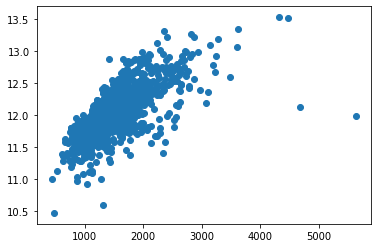

In [68]:
plt.scatter(df_clean['grlivarea'],np.log(df_clean['saleprice']))

In [101]:
X_train.loc[df_clean['grlivarea']>4000, :]

,overallqual,grlivarea,totalbsmtsf,garagearea,lotarea,nicehood,ageremodeled,agebuilt,agebuiltsquared,yrsold
691,10,4316,2444,832,21535,1,12,13,169,2007
1182,10,4476,2396,813,15623,1,11,11,121,2007


I'll go ahead an delete those

In [33]:
X_train.describe()

,overallqual,grlivarea,garagearea,totalbsmtsf,yearremodadd,yearbuilt,yrsbltqared,lotarea,nicehood
count,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,8.750000e+02,875.000000,875.000000
mean,6.240000,1536.194286,500.201143,1091.158857,1985.322286,1971.987429,3.889717e+06,10135.642286,0.205714
std,1.340958,539.152920,192.563219,425.017215,21.086048,31.362297,1.230836e+05,8820.403445,0.404454
min,2.000000,438.000000,160.000000,105.000000,1950.000000,1880.000000,3.534400e+06,1300.000000,0.000000
25%,5.000000,1161.000000,352.000000,814.500000,1966.000000,1953.000000,3.814209e+06,7593.000000,0.000000
50%,6.000000,1470.000000,484.000000,1004.000000,1995.000000,1974.000000,3.896676e+06,9360.000000,0.000000
75%,7.000000,1785.000000,592.000000,1312.500000,2004.000000,2003.000000,4.012009e+06,11380.500000,0.000000
max,10.000000,5642.000000,1418.000000,6110.000000,2010.000000,2010.000000,4.040100e+06,215245.000000,1.000000


Look into adding year sold as well as an age squared term.

I am also going to substitute ageremodeled and ageremodeled squared and see if it helps.

Also substitute total area for separate garage and living area.

In [105]:
df_clean=df_clean.drop([314,523,1298,452])

In [112]:
#Final Model
#new vars:
# df_clean['agebuilt']
# df_clean['ageremodeled']
# df_clean['agebuiltsquared']
# df_clean['ageremodeledsquared']
# df_clean['totalsf']

#df_clean=df_clean.drop([314,523,1298,452])


X3 = df_clean[['overallqual',
               'grlivarea',
               'totalbsmtsf',
               #'totalsf',
               'garagearea', 
               'lotarea',
               'nicehood',
               'ageremodeled',
               'agebuilt',
               'agebuiltsquared',
               'yrsold',
              ]]
Y2 = df_clean.saleprice
Y2_log=np.log(Y2)
X_train, X_test, y_log_train, y_log_test=train_test_split(X3,Y2_log,test_size=.2,random_state=1)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
results_log = sm.OLS(y_log_train, X_train_const).fit()
print(results_log.summary())
y_log_preds=results_log.predict(X_test_const)

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     594.0
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:38:38   Log-Likelihood:                 462.43
No. Observations:                 872   AIC:                            -902.9
Df Residuals:                     861   BIC:                            -850.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.4791      7.285     

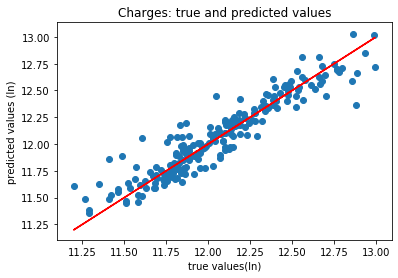

Mean absolute error of the prediction is: 17796.21629266301
Mean squared error of the prediction is: 721567444.9214021
Root mean squared error of the prediction is: 26862.007462611615
Mean absolute percentage error of the prediction is: 9.773541872852984


In [113]:
plt.scatter(y_log_test, y_log_preds)
plt.plot(y_log_test, y_log_test, color="red")
plt.xlabel("true values(ln)")
plt.ylabel("predicted values (ln)")
plt.title("Charges: true and predicted values")
plt.show()
y_test= np.exp(y_log_test)
y_preds=np.exp(y_log_preds)

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


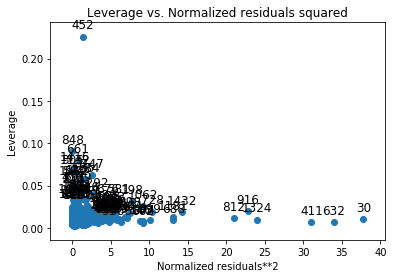

In [102]:
plot_leverage_resid2(results_log)
plt.show()

In [ ]:
sns.boxplot(x='yrsold',y='saleprice',data=df_clean)

I'm still overestimating a little on the low end and over on the high end, but I'm fairly happy.

Some further ideas are integrating the shiller index for iowa, and making the sale price in constant dollars.

Also, see if I really need the age built term.

It tends to overestimate low values. How to fix?

Maybe some things specific to Ames?

In [115]:
df_clean.yrsold.value_counts()

2009    246
2006    246
2007    244
2008    225
2010    129
Name: yrsold, dtype: int64